In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
import os
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
from tensorflow.keras.callbacks import ModelCheckpoint
from google.colab import files

In [3]:
train_path = '/content/gdrive/MyDrive/HM&UD/train'
classes = sorted(os.listdir(train_path))
class_indices = {c: i for i, c in enumerate(classes)}
class_info = ", ".join([f"{i}:{c}" for i, c in enumerate(classes)])
print(f"Class Information: {class_info}")

Class Information: 0:Apple, 1:Banana, 2:avocado, 3:cherry, 4:kiwi, 5:mango, 6:orange, 7:pinenapple, 8:strawberries, 9:watermelon


In [4]:
#First we instantiate Imagedata generator.
#We want to have the image rescaled in the range [0,1] so we set rescale as 1./255,
#the 1. is to have 1 as a floating point and be sure that 1/255 is treated as a floating point division
#We want also that training data is split into 80% train and 20% validation sets, so we set validation split as 0.2 (20%)
training_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )
test_datagen = ImageDataGenerator(
        rescale=1./255
    )

In [5]:
#We prepare the datasets. all codes are similar, let's see the training data to understand the general structure
train_ds=training_datagen.flow_from_directory(
    #first we get the folder where the images are stored in an organized way (like all apples in apple folder )
    "/content/gdrive/MyDrive/HM&UD/train",
    #we provide the list of classes to have a consistent ordering of classes between train and test set apple->0 banana->1 etc
    classes=classes,
    #how we want to load images, we want them as rgb images so with 3 channels
    color_mode="rgb",
    #size of batches to group images
    batch_size=64,
    #resize images to match this fixed dimension
    target_size=(256,256),
    #have classes one hot encoded
    class_mode="categorical",
    #get the training subset
    subset="training"
)

valid_ds=training_datagen.flow_from_directory(
    "/content/gdrive/MyDrive/HM&UD/train",
    classes=classes,
    color_mode="rgb",
    batch_size=64,
    target_size=(256,256),
    class_mode="categorical",
    subset="validation"
)

test_ds=training_datagen.flow_from_directory(
    "/content/gdrive/MyDrive/HM&UD/test",
    #this line is a bit different, but we are only fixing the name of the classes since the names of folders between train and test are inconsistent.
    classes=list(map(lambda x:x.lower().replace("strawberries","stawberries"),classes)),
    color_mode="rgb",
    batch_size=64,
    target_size=(256,256),
    class_mode="categorical"
)

Found 1841 images belonging to 10 classes.
Found 460 images belonging to 10 classes.
Found 1025 images belonging to 10 classes.


In [6]:
#define a CNN
model = tf.keras.models.Sequential([
    #A good dose of augmentation so that training data is hard to memorize but not too much to make the learning difficult
    layers.RandomRotation(0.1,input_shape=(256,256,3)),
    layers.RandomZoom(0.1),
    layers.RandomFlip(),
    layers.GaussianNoise(0.03),

    #convolutional portion
    layers.Conv2D(32, 3, activation='gelu'),
    layers.MaxPooling2D(4),
    layers.Conv2D(64, 3,  activation='gelu'),
    layers.MaxPooling2D(4),
    layers.Conv2D(128, 4,  activation='gelu'),
    layers.MaxPooling2D(4),
    layers.Flatten(),

    #Dense portion, with high dropout rate for a high regualization
    layers.Dense(128, activation='gelu'),
    layers.Dropout(0.65),
    layers.Dense(64, activation='gelu'),
    layers.Dropout(0.5),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])
#Compile the network with categorical crossentropy loss (since we used class_mode="categorical" in the flow from directory)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
# add callbacks for early stopping and lr reduction during training
callback_list=[
    callbacks.EarlyStopping(monitor="val_accuracy",patience=10,restore_best_weights=True),
    callbacks.ReduceLROnPlateau(factor=0.8,monitor="val_accuracy",patience=3)
]

In [7]:
#fit the model and validate on validation dataset
history=model.fit(train_ds,validation_data=valid_ds,epochs=200,verbose=1,callbacks=callback_list)

Epoch 1/200
29/29 [==============================] - 526s 18s/step - loss: 2.1979 - accuracy: 0.1646 - val_loss: 1.9889 - val_accuracy: 0.2522 - lr: 0.0020
Epoch 2/200
29/29 [==============================] - 9s 326ms/step - loss: 1.9620 - accuracy: 0.2716 - val_loss: 1.7288 - val_accuracy: 0.4087 - lr: 0.0020
Epoch 3/200
29/29 [==============================] - 8s 287ms/step - loss: 1.7845 - accuracy: 0.3172 - val_loss: 1.5760 - val_accuracy: 0.3978 - lr: 0.0020
Epoch 4/200
29/29 [==============================] - 10s 329ms/step - loss: 1.7377 - accuracy: 0.3254 - val_loss: 1.6591 - val_accuracy: 0.3587 - lr: 0.0020
Epoch 5/200
29/29 [==============================] - 9s 323ms/step - loss: 1.6748 - accuracy: 0.3335 - val_loss: 1.4972 - val_accuracy: 0.4217 - lr: 0.0020
Epoch 6/200
29/29 [==============================] - 9s 297ms/step - loss: 1.6543 - accuracy: 0.3574 - val_loss: 1.4856 - val_accuracy: 0.4370 - lr: 0.0020
Epoch 7/200
29/29 [==============================] - 10s 334ms/

In [8]:

import tensorflow as tf
from tensorflow.keras.models import load_model

# Assuming 'model' is your trained model
model.save('/content/gdrive/MyDrive/Dataset/fruit.h5')

# To load the model later
loaded_model = load_model('/content/gdrive/MyDrive/Dataset/fruit.h5')


Exception ignored in: <function _xla_gc_callback at 0x7a90b24fdc60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 101, in _xla_gc_callback
KeyboardInterrupt: 
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


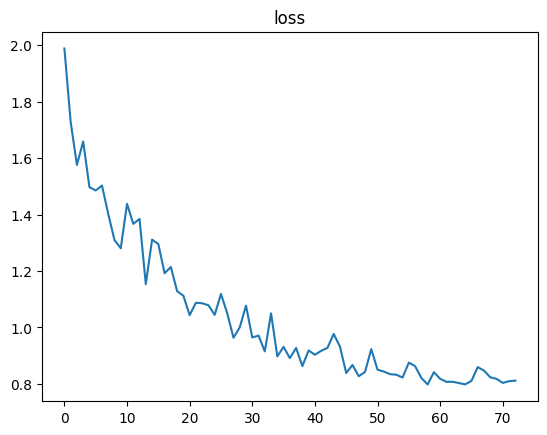

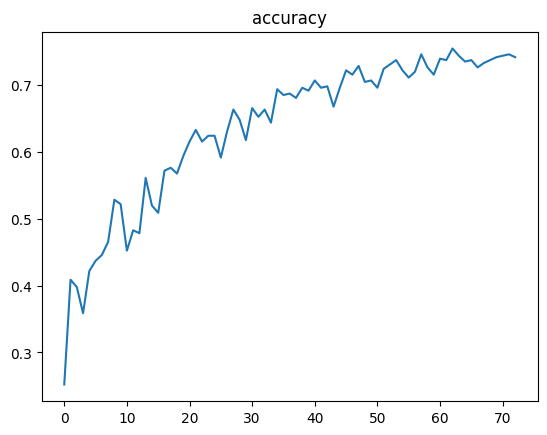

In [9]:
#Plot loss and accuracy on the validation set
plt.plot(history.history['val_loss'])
plt.title("loss")
plt.show()
plt.plot(history.history['val_accuracy'])
plt.title("accuracy")
plt.show()

In [10]:
model.evaluate(test_ds)

17/17 [==============================] - 247s 15s/step - loss: 0.8876 - accuracy: 0.7298


[0.8876364827156067, 0.7297561168670654]

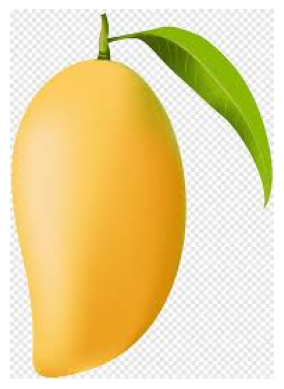

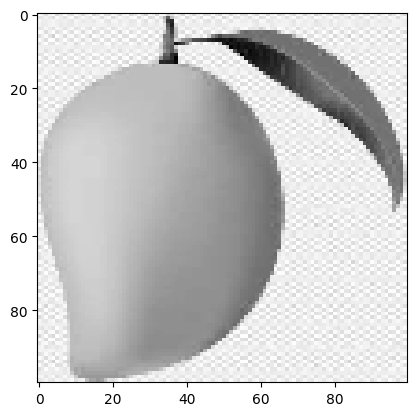

Show processed image


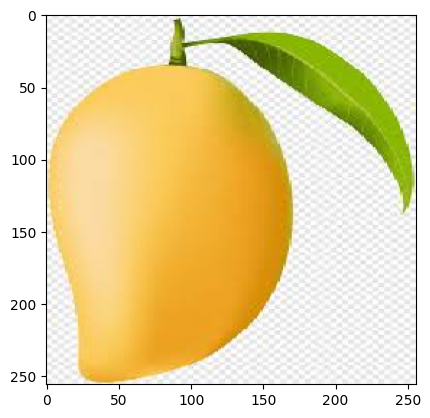

1/1 [==============================] - 0s 127ms/step
Predicted class: mango
Confidence: 0.86323845


In [90]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from tensorflow import keras

# Định nghĩa hàm img_test
def img_test(filepath):
    img = cv2.imread(filepath)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Định nghĩa hàm prepare
def prepare(filepath):
    IMG_SIZE = 100
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    new_array = new_array / 255.0
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

# Hiển thị ảnh từ hàm img_test
img_test('/content/gdrive/MyDrive/HM&UD/predict/img_421.jpeg')

# Chuẩn bị và hiển thị ảnh từ hàm prepare
prepared_image = prepare('/content/gdrive/MyDrive/HM&UD/predict/img_421.jpeg')
plt.imshow(np.squeeze(prepared_image), cmap="gray")
plt.show()
print('Show processed image')

# Tải mô hình đã được đào tạo
model = keras.models.load_model("/content/gdrive/MyDrive/Dataset/fruit.h5")

# Đường dẫn đến ảnh cần dự đoán
img_path = '/content/gdrive/MyDrive/HM&UD/predict/img_421.jpeg'  # Thay đổi đường dẫn này bằng ảnh bạn muốn dự đoán

# Chuẩn bị và hiển thị ảnh
img = image.load_img(img_path, target_size=(256, 256))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.0  # Chuẩn hóa giá trị pixel

plt.imshow(np.squeeze(img_tensor))
plt.show()

# Chuẩn bị danh sách loại trái cây
categories = ['apple', 'banana', 'avocado', 'cherry', 'kiwi', 'mango', 'orange', 'pinenapple', 'stawberries', 'watermelon']

# Dự đoán loại trái cây
prediction = model.predict(img_tensor)
predicted_class_index = np.argmax(prediction)
predicted_class = categories[predicted_class_index]
confidence = np.max(prediction)

# Hiển thị kết quả dự đoán và độ tin cậy
print('Predicted class:', predicted_class)
print('Confidence:', confidence)
